# Intro
It was possible to extract useful information from the Name column in the original Titanic competition. Despite that Name in Spaceship titanic has less information. Will check what insights can be received from it.

In [1]:
!pip install gender_guesser > /dev/null
import pandas as pd
import gender_guesser.detector as gender 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

d = gender.Detector()

NUM_ZERO = 0
NUM_ONE = 1

pd.set_option('display.max_columns', None)

df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.shape

(8693, 14)

## Filling missing values

In [2]:
missing_name_str = '* *'
df.Name = df.Name.fillna(missing_name_str).copy()

In [3]:
df['NameMissing'] = df.Name.apply(lambda x: True if x == missing_name_str else False)

df['FirstName'] = df.Name.apply(lambda x: x.split()[NUM_ZERO])
df['LastName'] = df.Name.apply(lambda x: x.split()[NUM_ONE])
df['FullNameLen'] = df.Name.apply(lambda x: len(x))
df['FirstNameLen'] = df.FirstName.apply(lambda x: len(x))
df['LastNameLen'] = df.LastName.apply(lambda x: len(x))

df['FirstNameVovel'] = df.FirstName.apply(lambda x: x[-1] in ['a','e','i','o','u'])
df['LastNameVovel'] = df.LastName.apply(lambda x: x[-1] in ['a','e','i','o','u'])


def has_pair_same_letters(string):
    for i in range(len(string) - 1):
        if string[i] == string[i+1]:
            return True
    return False

df['FirstNameSameLetters'] = df.FirstName.apply(lambda x: has_pair_same_letters(x))
df['LastNameSameLetters'] = df.LastName.apply(lambda x: has_pair_same_letters(x))

df['FullNameCount'] = df.groupby('Name')['Name'].transform('count')
df['FirstNameCount'] = df.groupby('FirstName')['FirstName'].transform('count')
df['LastNameCount'] = df.groupby('LastName')['LastName'].transform('count')

df['LastNameHasRelative'] = False
for i in range(1, len(df) - 1):
    if df.iloc[i-1]['LastName'] == df.iloc[i]['LastName'] or df.iloc[i]['LastName'] == df.iloc[i+1]['LastName']:
        df.at[i, 'LastNameHasRelative'] = True

df['NameLengthRatio'] = df['FirstNameLen'] / df['LastNameLen']
df['FirstNameFirstLetter'] = df.FirstName.apply(lambda x: x[0])
df['LastNameFirstLetter'] = df.LastName.apply(lambda x: x[0])
df['Intials'] = df['FirstNameFirstLetter'] + df['LastNameFirstLetter'] 
df['IntialsCount'] = df.groupby('Intials')['Intials'].transform('count')

df['Gender'] = df.FirstName.apply(lambda x: d.get_gender(x))


In [4]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,NameMissing,FirstName,LastName,FullNameLen,FirstNameLen,LastNameLen,FirstNameVovel,LastNameVovel,FirstNameSameLetters,LastNameSameLetters,FullNameCount,FirstNameCount,LastNameCount,LastNameHasRelative,NameLengthRatio,FirstNameFirstLetter,LastNameFirstLetter,Intials,IntialsCount,Gender
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,False,Maham,Ofracculy,15,5,9,False,False,False,True,1,4,1,False,0.555556,M,O,MO,12,unknown
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,False,Juanna,Vines,12,6,5,True,False,True,False,1,6,4,False,1.200000,J,V,JV,9,unknown


## Mutual Information

In [5]:
# Only new columns that was generated from the Nameant the Transported
# Without the 'FirstName','LastName'
df_names = df[['NameMissing','FullNameLen','FirstNameLen','LastNameLen','FirstNameVovel','LastNameVovel','FirstNameSameLetters','LastNameSameLetters','FullNameCount','FirstNameCount','LastNameCount','LastNameHasRelative','NameLengthRatio','FirstNameFirstLetter','LastNameFirstLetter','Intials','IntialsCount','Gender', 'Transported']].copy()

In [6]:
df_names.head(2)

,NameMissing,FullNameLen,FirstNameLen,LastNameLen,FirstNameVovel,LastNameVovel,FirstNameSameLetters,LastNameSameLetters,FullNameCount,FirstNameCount,LastNameCount,LastNameHasRelative,NameLengthRatio,FirstNameFirstLetter,LastNameFirstLetter,Intials,IntialsCount,Gender,Transported
0,False,15,5,9,False,False,False,True,1,4,1,False,0.555556,M,O,MO,12,unknown,False
1,False,12,6,5,True,False,True,False,1,6,4,False,1.200000,J,V,JV,9,unknown,True


In [7]:
X = df_names.copy()
y = X.pop("Transported")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

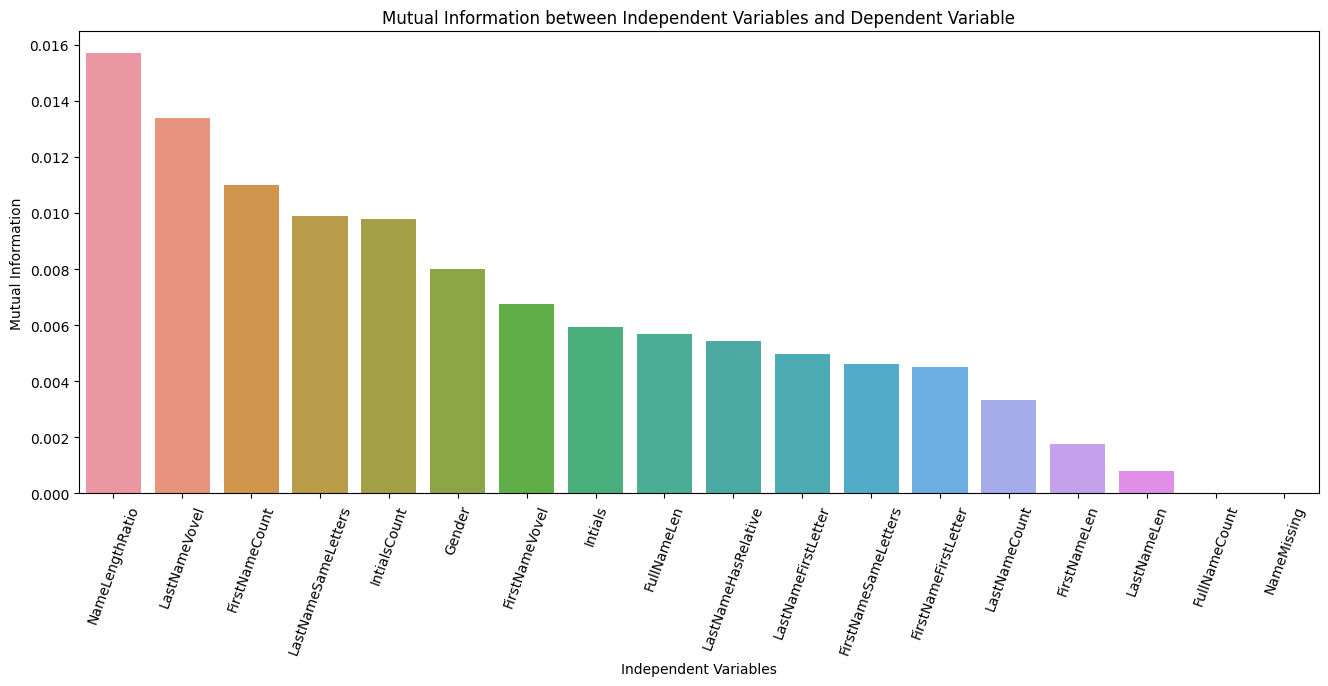

In [8]:
mi = mutual_info_regression(X, y)

# Create a DataFrame to hold the mutual information values and corresponding column names
mi_df = pd.DataFrame({'feature': X.columns, 'mi': mi})
mi_df = mi_df.sort_values(by='mi', ascending=False)  # Sort the DataFrame by mutual information values

# Plot the mutual information
plt.figure(figsize=(16, 6))
sns.barplot(x=mi_df['feature'], y=mi_df['mi'], order=mi_df['feature'])
plt.title('Mutual Information between Independent Variables and Dependent Variable')
plt.xlabel('Independent Variables')
plt.ylabel('Mutual Information')
plt.xticks(rotation=70)
plt.show()

Gender Guesser library doesn't recognize most of the names in this dataset. The data is generated, therefore the names can be fictional. Usage of an LLM probably will give a better result.

## Model
The focus of this notebook is only the Name column. Making predictions based only on the new features.

In [9]:
df_names.Transported = df_names.Transported.apply(lambda x: int(x)).copy()
df_names.FirstNameFirstLetter = df_names.FirstNameFirstLetter.astype('category').cat.codes
df_names.LastNameFirstLetter = df_names.LastNameFirstLetter.astype('category').cat.codes
df_names.Intials = df_names.Intials.astype('category').cat.codes
df_names.Gender = df_names.Gender.astype('category').cat.codes

In [10]:
X = df_names.drop('Transported',axis=1)
y = df_names.Transported
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [11]:
tree_model = DecisionTreeClassifier(random_state=2)
tree_model.fit(X_train,y_train)
tree_model.score(X_test,y_test)

0.5267395054629097

In [12]:
forest_model = RandomForestClassifier(random_state=2)
forest_model.fit(X_train,y_train)
forest_model.score(X_test,y_test)

0.5445658424381828

In [13]:
xgboost_model = XGBClassifier(random_state=2)
xgboost_model.fit(X_train,y_train)
xgboost_model.score(X_test,y_test)

0.5485911443358252

In [14]:
catboost_model = CatBoostClassifier(random_state=2)
catboost_model.fit(X_train,y_train, logging_level = 'Silent')
catboost_model.score(X_test,y_test)

0.5687176538240368

Catboost achieved the highest score.